## Описание проекта

Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих бурёнок!

Поэтому он просит нас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:

Первая будет прогнозировать возможный удой у коровы (целевой признак Удой);

Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:

1. Средний удой за год — не менее 6000 килограммов,
2. Молоко должно быть вкусным.

In [1]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer

## Загрузка данных

In [2]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv',sep=';', decimal=',')
ferma_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [3]:
# переименование столбцов
ferma_main = ferma_main.rename(columns={
    'Удой, кг': 'milk_yield',
    'ЭКЕ (Энергетическая кормовая единица)': 'energy_feed_unit',
    'Сырой протеин, г': 'crude_protein',
    'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio',
    'Порода': 'breed',
    'Тип пастбища': 'type_of_pasture',
    'порода папы_быка': "dad's_breed",
    'Жирность,%': 'fat_content',
    'Белок,%': 'protein',
    'Вкус молока': 'taste_of_milk',
    'Возраст': 'age'
})
ferma_main.head()

,id,milk_yield,energy_feed_unit,crude_protein,sugar_protein_ratio,breed,type_of_pasture,dad's_breed,fat_content,protein,taste_of_milk,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [4]:
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv',sep=';')
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [5]:
# переименование столбцов
ferma_dad = ferma_dad.rename(columns={'Имя Папы': "dad's_name"})
ferma_dad.head()

,id,dad's_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [6]:
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [7]:
# переименование столбцов
cow_buy = cow_buy.rename(columns={
    'Порода': 'breed',
    'Тип пастбища': 'type_of_pasture',
    'порода папы_быка': "dad's_breed",
    'Имя_папы': "dad's_name",
    'Текущая_жирность,%': 'current_fat_content',
    'Текущий_уровень_белок,%': 'current_protein_level',
    'Возраст': 'age'
})
cow_buy.head()

,breed,type_of_pasture,dad's_breed,dad's_name,current_fat_content,current_protein_level,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


Все файлы были загружены как датафреймы, а наименования столбцов были приведены к стандарту.

##  Предобработка данных

In [8]:
ferma_main.head()

,id,milk_yield,energy_feed_unit,crude_protein,sugar_protein_ratio,breed,type_of_pasture,dad's_breed,fat_content,protein,taste_of_milk,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [9]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   634 non-null    int64  
 1   milk_yield           634 non-null    int64  
 2   energy_feed_unit     634 non-null    float64
 3   crude_protein        634 non-null    int64  
 4   sugar_protein_ratio  634 non-null    float64
 5   breed                634 non-null    object 
 6   type_of_pasture      634 non-null    object 
 7   dad's_breed          634 non-null    object 
 8   fat_content          634 non-null    float64
 9   protein              634 non-null    float64
 10  taste_of_milk        634 non-null    object 
 11  age                  634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [10]:
ferma_main.shape

(634, 12)

Пропущенных значений нет, зато стоит изменить типы данных в столбцах с колличественными данными.

In [11]:
# замечено, что в данных стоит запятая вместо точки, необходимо привести всё в нужный вид, потом сменить тип
cols_to_conv = ['energy_feed_unit', 'sugar_protein_ratio', 'fat_content', 'protein']

for col in cols_to_conv:
    ferma_main[col] = ferma_main[col].astype(float)
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   634 non-null    int64  
 1   milk_yield           634 non-null    int64  
 2   energy_feed_unit     634 non-null    float64
 3   crude_protein        634 non-null    int64  
 4   sugar_protein_ratio  634 non-null    float64
 5   breed                634 non-null    object 
 6   type_of_pasture      634 non-null    object 
 7   dad's_breed          634 non-null    object 
 8   fat_content          634 non-null    float64
 9   protein              634 non-null    float64
 10  taste_of_milk        634 non-null    object 
 11  age                  634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [12]:
# посмотрим дуликаты
ferma_main[ferma_main.duplicated()]

,id,milk_yield,energy_feed_unit,crude_protein,sugar_protein_ratio,breed,type_of_pasture,dad's_breed,fat_content,protein,taste_of_milk,age
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


In [13]:
ferma_main = ferma_main.drop_duplicates()
ferma_main.duplicated().sum()

0

In [14]:
ferma_main['type_of_pasture'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

Думаю "равнинное" и "равнинные" одно и то же, приведем все к порядку.

In [15]:
ferma_main['type_of_pasture'] = ferma_main['type_of_pasture'].replace({'Равнинные': 'Равнинное'})
ferma_main['type_of_pasture'].unique()

array(['Равнинное', 'Холмистое'], dtype=object)

In [16]:
ferma_main["dad's_breed"].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [17]:
# аналогично выглядит что Айдиал и Айдиалл одно и то же
ferma_main["dad's_breed"] = ferma_main["dad's_breed"].replace({'Айдиалл': 'Айдиал'})
ferma_main["dad's_breed"].unique()

array(['Айдиал', 'Соверин'], dtype=object)

<div style="background-color: #d4edda; color: #155724; padding: 15px;a border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Комментарий ревьюера v1:</b>
    
Хорошее решение для приведения данных к единому формату.
 

In [18]:
ferma_main.nunique()

id                     629
milk_yield             528
energy_feed_unit        55
crude_protein          401
sugar_protein_ratio     12
breed                    2
type_of_pasture          2
dad's_breed              2
fat_content             50
protein                 15
taste_of_milk            2
age                      2
dtype: int64

In [19]:
# проверим что не потеряли размерность (-5 дублирующихся строк)
ferma_main.shape

(629, 12)

In [20]:
ferma_main.head()

,id,milk_yield,energy_feed_unit,crude_protein,sugar_protein_ratio,breed,type_of_pasture,dad's_breed,fat_content,protein,taste_of_milk,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


Берем слудеющий датафрейм.

In [21]:
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          629 non-null    int64 
 1   dad's_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [22]:
ferma_dad[ferma_dad.duplicated()]

,id,dad's_name


In [23]:
ferma_dad["dad's_name"].unique()

array(['Буйный', 'Соловчик', 'Барин', 'Геркулес'], dtype=object)

Пропущенных значений нет, дубликатов тоже. Все хорошо. Смотрим следующий.

In [24]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   breed                  20 non-null     object 
 1   type_of_pasture        20 non-null     object 
 2   dad's_breed            20 non-null     object 
 3   dad's_name             20 non-null     object 
 4   current_fat_content    20 non-null     float64
 5   current_protein_level  20 non-null     float64
 6   age                    20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [25]:
cow_buy.shape

(20, 7)

In [26]:
# замечены запятые и некорректный тип данных.
cols_to_conv = ['current_fat_content', 'current_protein_level']

for col in cols_to_conv:
    cow_buy[col] = cow_buy[col].astype(float)
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   breed                  20 non-null     object 
 1   type_of_pasture        20 non-null     object 
 2   dad's_breed            20 non-null     object 
 3   dad's_name             20 non-null     object 
 4   current_fat_content    20 non-null     float64
 5   current_protein_level  20 non-null     float64
 6   age                    20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [27]:
# дубликаты
cow_buy[cow_buy.duplicated()]

,breed,type_of_pasture,dad's_breed,dad's_name,current_fat_content,current_protein_level,age
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [28]:
cow_buy = cow_buy.drop_duplicates().reset_index(drop=True)
cow_buy.duplicated().sum()

0

In [29]:
cow_buy['type_of_pasture'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [30]:
# приведем к единому заполнению
cow_buy['type_of_pasture'] = cow_buy['type_of_pasture'].str.capitalize()
cow_buy['type_of_pasture'].unique()

array(['Холмистое', 'Равнинное'], dtype=object)

In [31]:
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   breed                  16 non-null     object 
 1   type_of_pasture        16 non-null     object 
 2   dad's_breed            16 non-null     object 
 3   dad's_name             16 non-null     object 
 4   current_fat_content    16 non-null     float64
 5   current_protein_level  16 non-null     float64
 6   age                    16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB


In [32]:
cow_buy.shape

(16, 7)

In [33]:
cow_buy.nunique()

breed                     2
type_of_pasture           2
dad's_breed               2
dad's_name                4
current_fat_content      12
current_protein_level    12
age                       2
dtype: int64

### Вывод

Были изменены типы данных в датафреймах ferma_main и cow_buy со строки на тип float будет полезно при расчетах. Еще были замечены полные дубликаты в данных таблицах, они удалены (теперь на 4 коровы стало меньше для выбора покупки). Пропусков нет.

## Исследовательский анализ данных

In [34]:
# создадим функции для отображения графиков
def plot_distribution(df, column, bins=30, title=None):
    """
    Функция рисует гистограмму и boxplot для столбца с колличественными данными.
    """
    
    # создаем фигуру с двумя графиками
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # гистограмма
    sns.histplot(df[column], bins=bins, ax=axes[0], kde=True)
    axes[0].set_title(f'Распределение данных "{title}"')
    axes[0].set_xlabel(title)
    axes[0].set_ylabel('Частота')

    # boxplot
    sns.boxplot(x=df[column], ax=axes[1])
    axes[1].set_title(f'Boxplot "{title}"')
    axes[1].set_xlabel(title)

    plt.tight_layout()
    plt.show()

def plot_categorical(df, column, title=None):
    """
    Функция рисует pie chart для столбца с категориальными данными.
    """
    
    # считаем количество для каждой категории
    counts = df[column].value_counts()
    
    plt.figure(figsize=(7, 7))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')  # чтобы круг был кругом, а не овалом
    plt.show()

### Данные о стаде фермера

In [35]:
# выведем основные описательные статистики
ferma_main.describe()

,id,milk_yield,energy_feed_unit,crude_protein,sugar_protein_ratio,fat_content,protein
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


In [36]:
ferma_main.describe(include='object')

,breed,type_of_pasture,dad's_breed,taste_of_milk,age
count,629,629,629,629,629
unique,2,2,2,2,2
top,Вис Бик Айдиал,Холмистое,Айдиал,вкусно,более_2_лет
freq,373,351,318,371,519


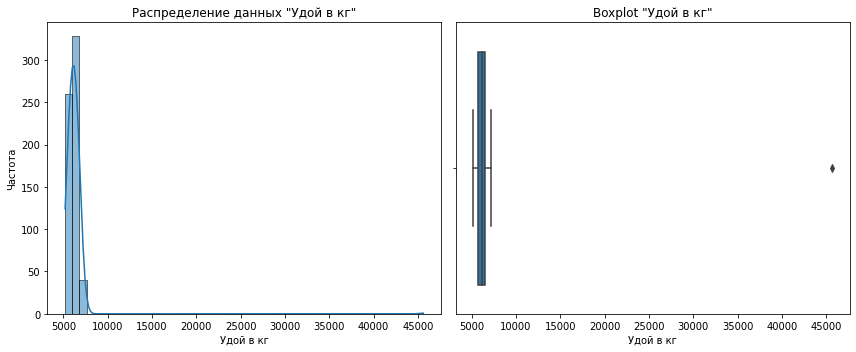

In [37]:
plot_distribution(ferma_main,'milk_yield', 50, 'Удой в кг')

In [38]:
# есть выброс в столбце, посмотрим на него
ferma_main.sort_values(by='milk_yield', ascending=False)

,id,milk_yield,energy_feed_unit,crude_protein,sugar_protein_ratio,breed,type_of_pasture,dad's_breed,fat_content,protein,taste_of_milk,age
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет
70,71,7222,16.8,2157,0.95,Вис Бик Айдиал,Холмистое,Айдиал,3.70,3.076,вкусно,более_2_лет
135,136,7207,16.6,2343,0.94,Вис Бик Айдиал,Холмистое,Айдиал,3.72,3.078,вкусно,более_2_лет
296,297,7201,15.8,2077,0.94,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.072,вкусно,более_2_лет
294,295,7197,15.6,2241,0.94,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.075,вкусно,более_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
578,579,5235,12.2,1724,0.86,РефлешнСоверинг,Холмистое,Соверин,3.28,3.078,не вкусно,менее_2_лет
322,323,5215,13.1,1741,0.84,РефлешнСоверинг,Равнинное,Соверин,3.18,3.070,не вкусно,менее_2_лет
589,590,5213,12.1,2016,0.88,РефлешнСоверинг,Равнинное,Соверин,3.19,3.076,не вкусно,менее_2_лет
397,398,5207,13.3,1829,0.89,РефлешнСоверинг,Холмистое,Соверин,3.48,3.077,не вкусно,менее_2_лет


Корова, я думаю, не способна дать столько молока, поэтому предположу, что при внесении данных была ошибка, но на указание в граммах не похоже, а гадать рискованно, лучше уберу эту строку из выборки.

In [39]:
ferma_main = ferma_main[ferma_main['milk_yield'] != 45616]
ferma_main.sort_values(by='milk_yield', ascending=False) # проверяем

,id,milk_yield,energy_feed_unit,crude_protein,sugar_protein_ratio,breed,type_of_pasture,dad's_breed,fat_content,protein,taste_of_milk,age
70,71,7222,16.8,2157,0.95,Вис Бик Айдиал,Холмистое,Айдиал,3.70,3.076,вкусно,более_2_лет
135,136,7207,16.6,2343,0.94,Вис Бик Айдиал,Холмистое,Айдиал,3.72,3.078,вкусно,более_2_лет
296,297,7201,15.8,2077,0.94,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.072,вкусно,более_2_лет
294,295,7197,15.6,2241,0.94,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.075,вкусно,более_2_лет
593,594,7174,16.7,2318,0.95,РефлешнСоверинг,Холмистое,Айдиал,3.72,3.074,вкусно,более_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
578,579,5235,12.2,1724,0.86,РефлешнСоверинг,Холмистое,Соверин,3.28,3.078,не вкусно,менее_2_лет
322,323,5215,13.1,1741,0.84,РефлешнСоверинг,Равнинное,Соверин,3.18,3.070,не вкусно,менее_2_лет
589,590,5213,12.1,2016,0.88,РефлешнСоверинг,Равнинное,Соверин,3.19,3.076,не вкусно,менее_2_лет
397,398,5207,13.3,1829,0.89,РефлешнСоверинг,Холмистое,Соверин,3.48,3.077,не вкусно,менее_2_лет


In [40]:
ferma_main.describe()

,id,milk_yield,energy_feed_unit,crude_protein,sugar_protein_ratio,fat_content,protein
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,315.474522,6125.968153,14.548726,1923.759554,0.913089,3.604268,3.075670
std,181.475367,475.857053,1.301777,182.832816,0.032221,0.168093,0.002551
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.750000,5749.750000,13.500000,1771.750000,0.890000,3.590000,3.074000
50%,315.500000,6132.500000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.250000,6501.000000,15.600000,2062.250000,0.940000,3.720000,3.077000
max,629.000000,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


In [41]:
ferma_main.describe(include='object')

,breed,type_of_pasture,dad's_breed,taste_of_milk,age
count,628,628,628,628,628
unique,2,2,2,2,2
top,Вис Бик Айдиал,Холмистое,Айдиал,вкусно,более_2_лет
freq,372,350,317,370,518


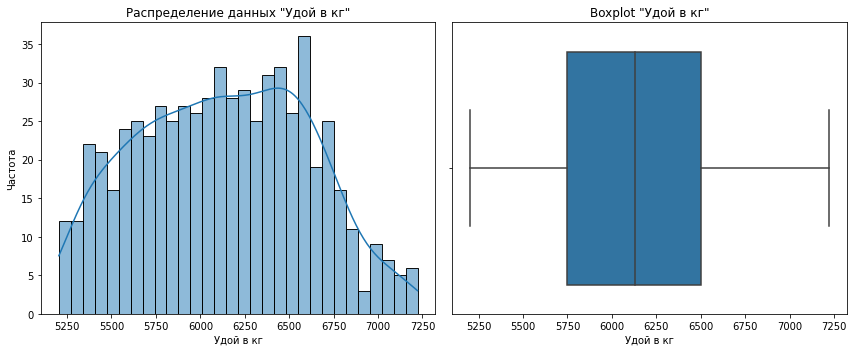

In [42]:
plot_distribution(ferma_main,'milk_yield', 30, 'Удой в кг')

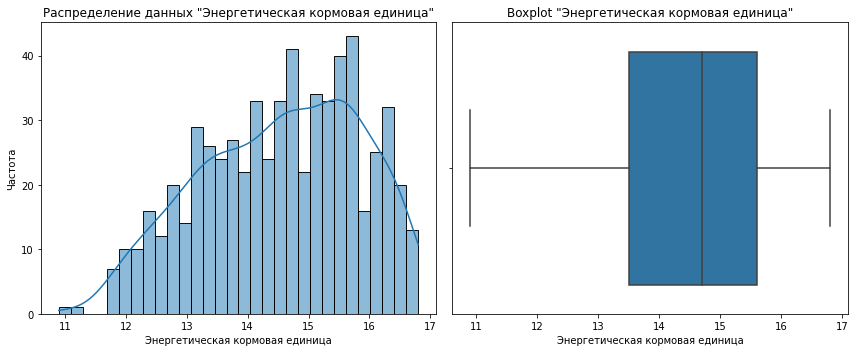

In [43]:
plot_distribution(ferma_main,'energy_feed_unit', 30, 'Энергетическая кормовая единица')

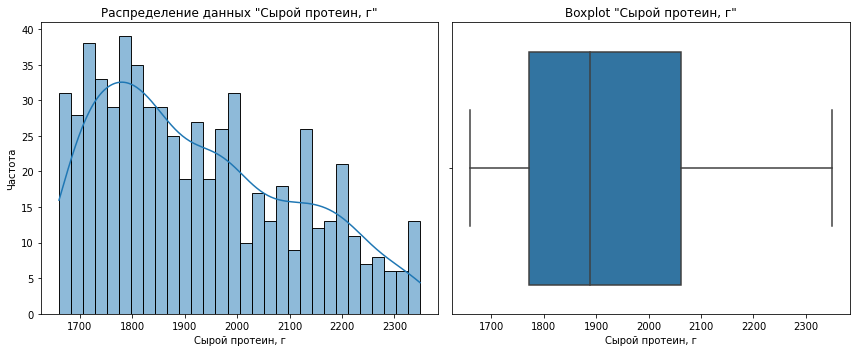

In [44]:
plot_distribution(ferma_main,'crude_protein', 30, 'Сырой протеин, г')

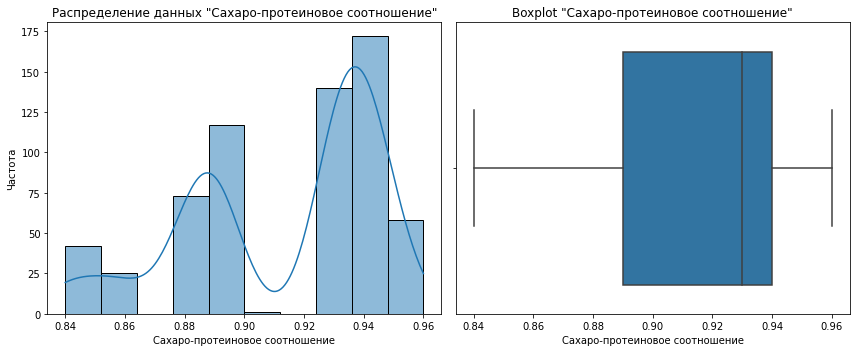

In [45]:
plot_distribution(ferma_main,'sugar_protein_ratio', 10, 'Сахаро-протеиновое соотношение')

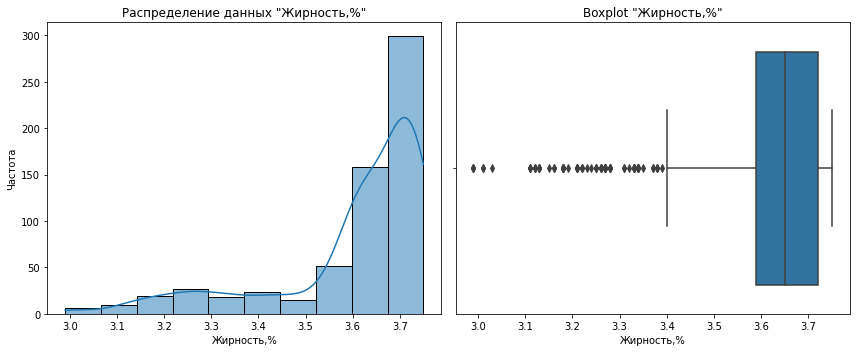

In [46]:
plot_distribution(ferma_main,'fat_content', 10, 'Жирность,%')

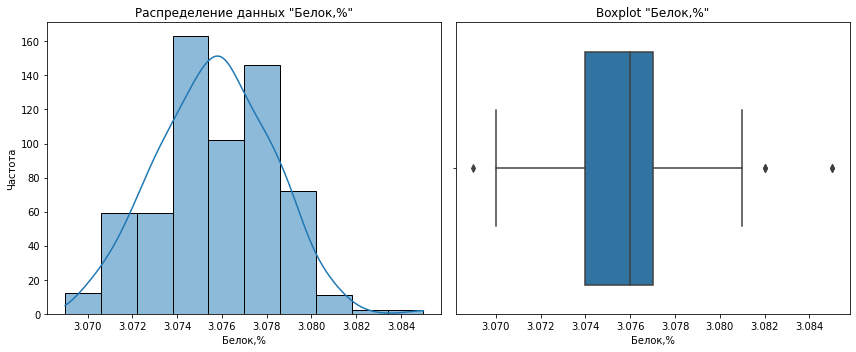

In [47]:
plot_distribution(ferma_main,'protein', 10, 'Белок,%')

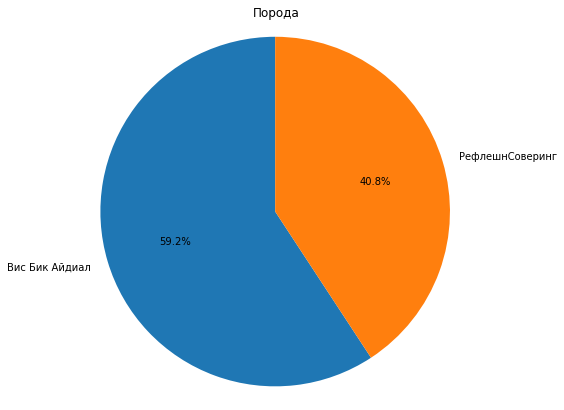

In [48]:
plot_categorical(ferma_main, 'breed', 'Порода')

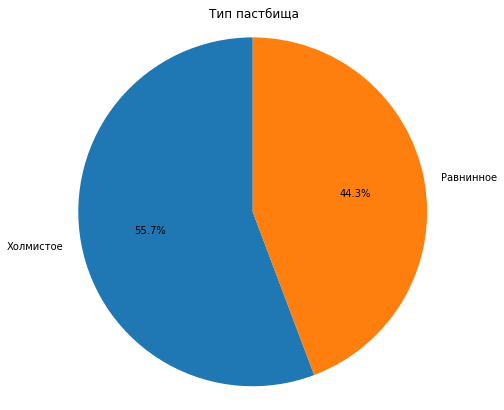

In [49]:
plot_categorical(ferma_main, 'type_of_pasture', 'Тип пастбища')

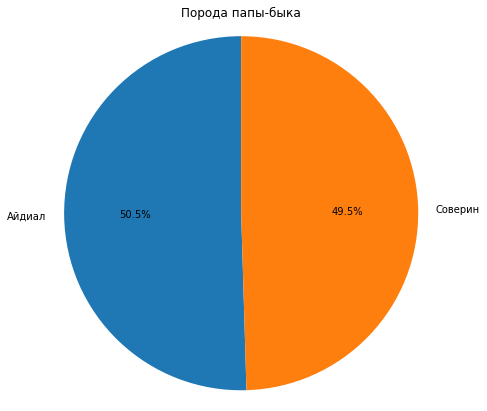

In [50]:
plot_categorical(ferma_main, "dad's_breed", 'Порода папы-быка')

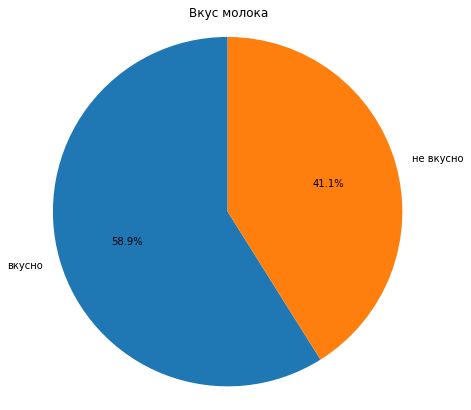

In [51]:
plot_categorical(ferma_main, 'taste_of_milk', 'Вкус молока')

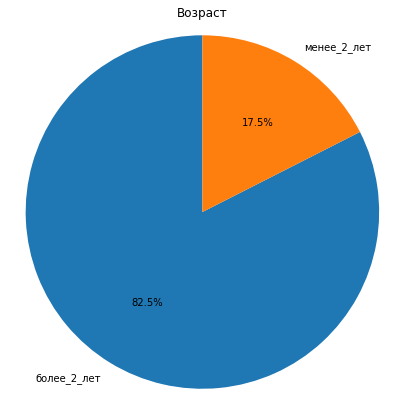

In [52]:
plot_categorical(ferma_main, 'age', 'Возраст')

#### Вывод по данным о стаде фермера

Был обнаружен выброс в виде 45616 кг удоя в год, данные неправдоподобны, поэтому данная строка была удалена из датафрейма. Также показаны в boxplot выбросы в проценте жирности и белка, но их убирать не буду.

В данных о стаде фермера 628 коров. Большая часть стада старше 2х лет, дает вкусное молоко, пасется на холмистом пастбище и породы Вис Бик Айдиал. Породы отцов быков примерно поровну.

Средние характеристики корма: 
1. ЭКЕ в среднем от 13,5 до 15,6 (среднее 14,55).
2. Сырой протеин в основном от 1771.75 гр до 2062,25 (медиана 1888 гр).
3. СПО в промежутке от 0,89 до 0,94 (медиана 0.93).

Средние характеристики молока:
1. Удой в основном от 5749 до 6501 кг в среднем 6125.97 кг.
2. Процент жирности от 3.59 до 3.72 (медиана 3.65 %).
3. Процент белка от 3.074 до 3.077 (среднее 3.076 %).

Брала в некоторых пунктах медиану, т.к. данные на графиках скошены в большую или меньшую стороны, а это влияет на среднее значение.

### Данные об отцах коров из стаде фермера

In [53]:
ferma_dad.describe(include='object')

,dad's_name
count,629
unique,4
top,Барин
freq,240


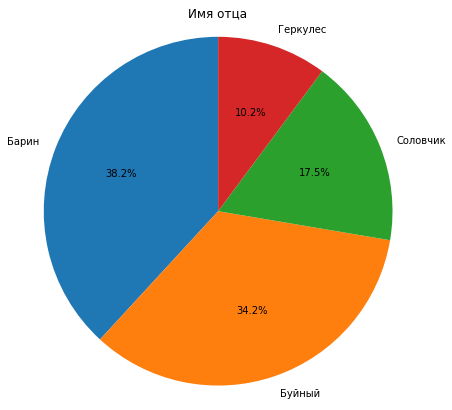

In [54]:
plot_categorical(ferma_dad, "dad's_name", 'Имя отца')

#### Вывод по данным об имени отца из стада фермера

Топ-3 отцов по количеству коров:
1. Барин
2. Буйный
3. Соловчик

### Данные о коровах "ЭкоФермы"

In [55]:
cow_buy.describe()

,current_fat_content,current_protein_level
count,16.000000,16.000000
mean,3.571875,3.068250
std,0.141620,0.011264
min,3.340000,3.046000
25%,3.415000,3.059500
50%,3.585000,3.073500
75%,3.692500,3.076750
max,3.770000,3.081000


In [56]:
cow_buy.describe(include='object')

,breed,type_of_pasture,dad's_breed,dad's_name,age
count,16,16,16,16,16
unique,2,2,2,4,2
top,Вис Бик Айдиал,Равнинное,Соверин,Буйный,более_2_лет
freq,8,8,10,7,11


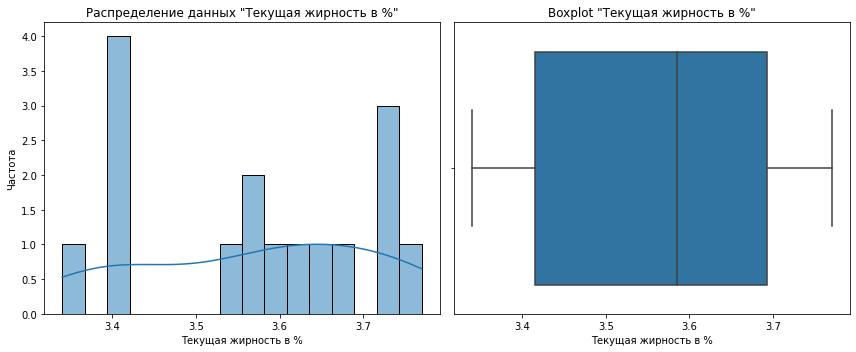

In [57]:
plot_distribution(cow_buy,'current_fat_content', 16, 'Текущая жирность в %')

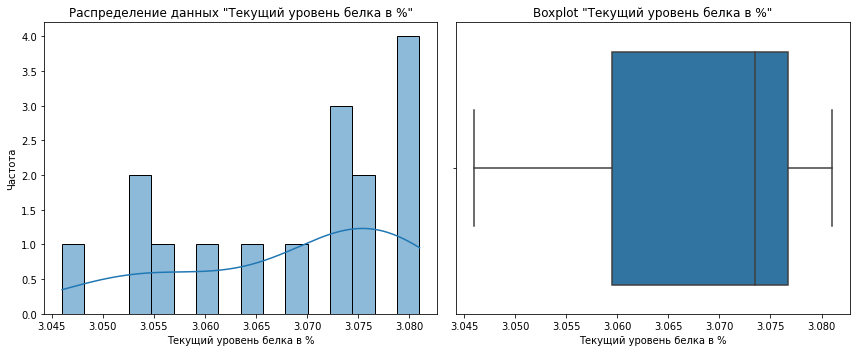

In [58]:
plot_distribution(cow_buy,'current_protein_level', 16, 'Текущий уровень белка в %')

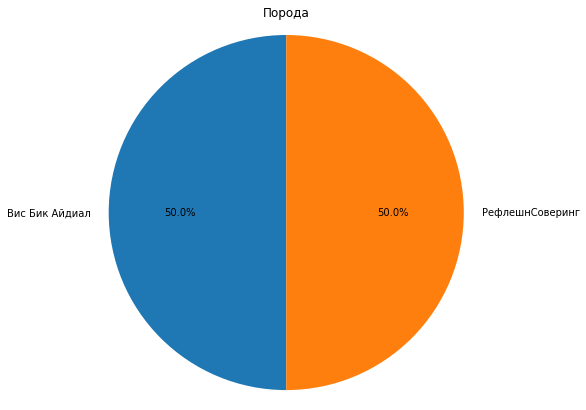

In [59]:
plot_categorical(cow_buy, 'breed', 'Порода')

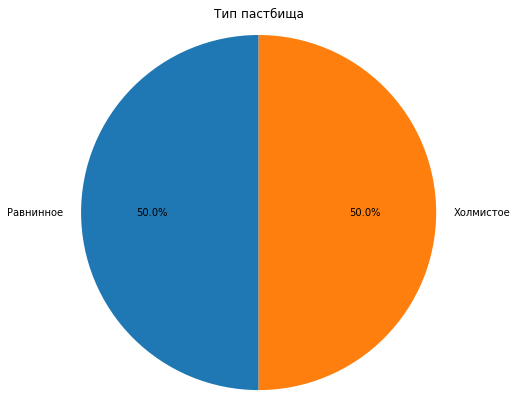

In [60]:
plot_categorical(cow_buy, 'type_of_pasture', 'Тип пастбища')

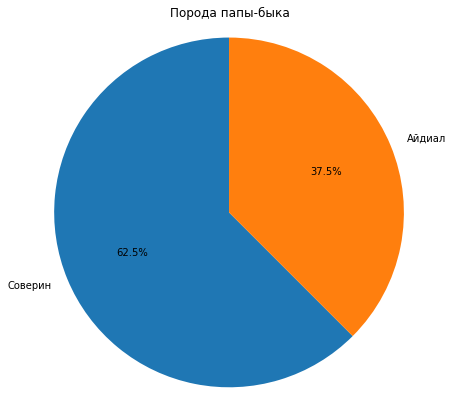

In [61]:
plot_categorical(cow_buy, "dad's_breed", 'Порода папы-быка')

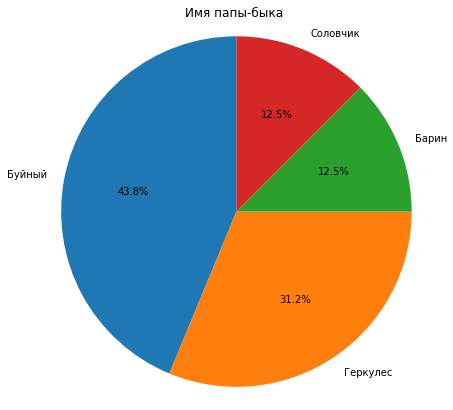

In [62]:
plot_categorical(cow_buy, "dad's_name", 'Имя папы-быка')

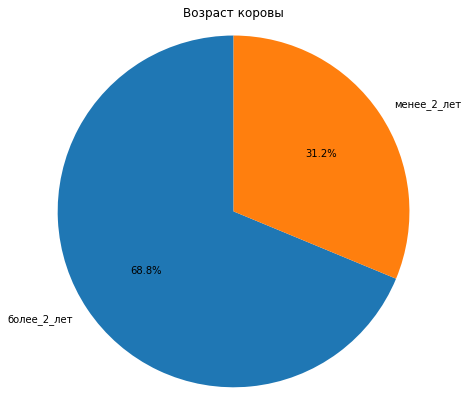

In [63]:
plot_categorical(cow_buy, 'age', 'Возраст коровы')

#### Вывод по данным окоровах с "ЭкоФермы"

Жирность молока у большинства коров от 3,5% (среднее 3,57%), а уровень белка от 3.059 до 3.076 (среднее 3.07).

Породы коров как и тип пастбища ровно поровну 50 на 50%. Также большая часть коров старше 2х лет.

Топ-3 отцов по количеству коров:
1. Буйный
2. Геркулес
3. Соловчик/Барин

Преобладает порода папы-быка Соверин.


## Корреляционный анализ

In [64]:
# сделаем функцию для построения диаграмм рассеярия для признака удой и всех колличественных признаков  
# с учетом значения категориальных признаков

num_features = ['energy_feed_unit', 'crude_protein', 'sugar_protein_ratio', 'fat_content', 'protein']

def plot_scatter_by_category(df, num_features, category, target='milk_yield', title='Заголовок графиков', ncols=3):
    """
    функция строит scatterplot между целевым признаком и числовыми признаками,
    с цветовым разделением по категориальному признаку.
    """
    
    nplots = len(num_features)
    nrows = (nplots // ncols) + (1 if nplots % ncols > 0 else 0)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
    axes = axes.flatten() 

    # цикл по каждому числовому признаку
    for i, feature in enumerate(num_features):
        sns.scatterplot(
            ax=axes[i],
            data=ferma_main,
            x=feature,
            y=target,
            hue=category,
            alpha=0.7,
            edgecolor=None
        )
        axes[i].set_title(f'{target.replace("_", " ").title()} и {feature.replace("_", " ").title()}')
        axes[i].set_xlabel(feature.replace('_', ' ').title())
        axes[i].grid(True)

    # Общий заголовок
    plt.suptitle(title, fontsize=14, y=1)
    plt.tight_layout()
    plt.show()

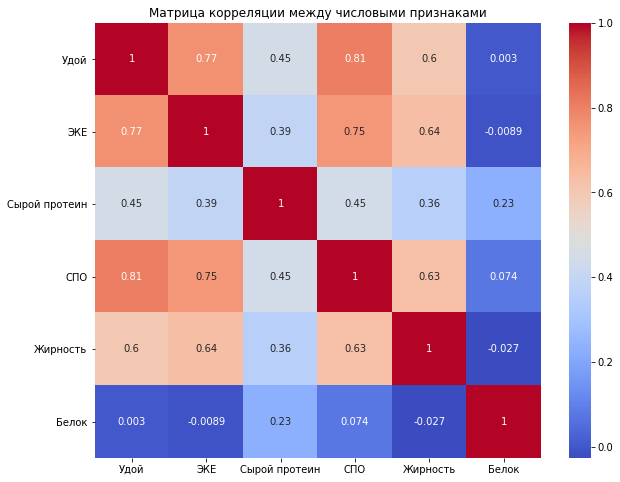

In [65]:
# чтобы посчитать корреляцию, необходимо выбрать столбцы с колличественными данными
num_cols = [
    'milk_yield',
    'energy_feed_unit',
    'crude_protein',
    'sugar_protein_ratio',
    'fat_content',
    'protein'
]
corr_df = ferma_main[num_cols]
corr_df = corr_df.rename(columns={
    'milk_yield': 'Удой',
    'energy_feed_unit': 'ЭКЕ',
    'crude_protein': 'Сырой протеин',
    'sugar_protein_ratio': 'СПО',
    'fat_content': 'Жирность',
    'protein': 'Белок'
})

# визуализируем корреляционную матрицу
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляции между числовыми признаками')
plt.show()

Мы видим, что при увеличении таких параметров, как ЭКЕ и СПО, можно ожидать увеличения годового удоя. При этом уровень белка в молоке не влияет на объём молока, а другие факторы, оказывают лишь умеренное воздействие.


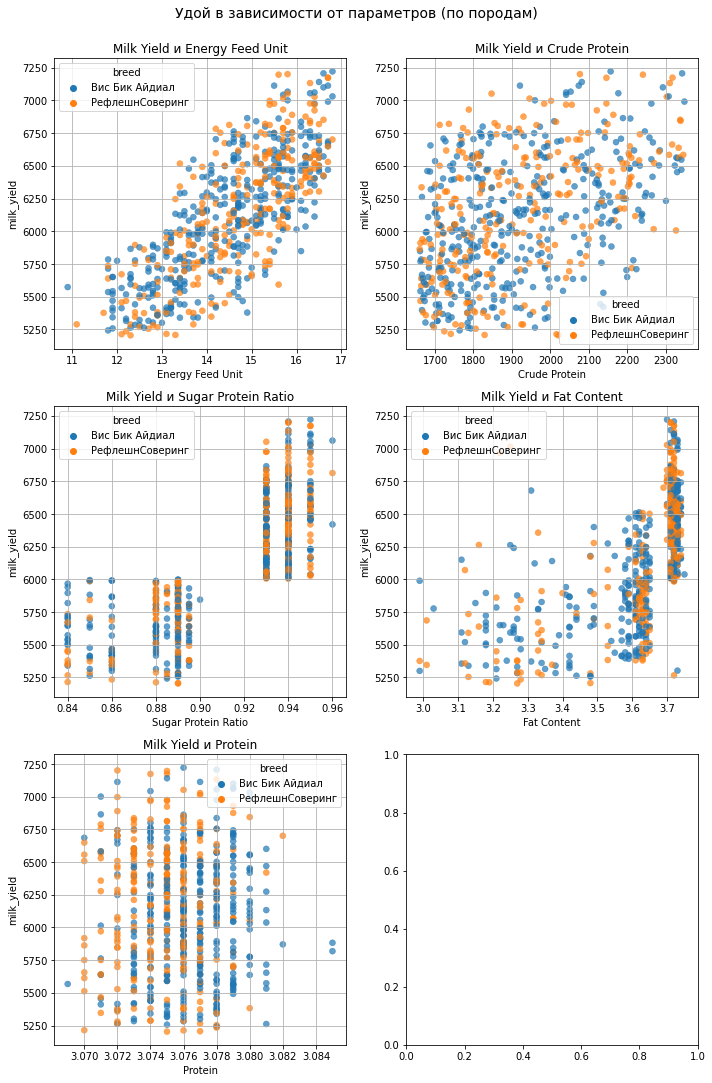

In [66]:
plot_scatter_by_category(
    df=ferma_main,
    num_features=num_features,
    category='breed',
    target='milk_yield',
    title='Удой в зависимости от параметров (по породам)',
    ncols=2
)

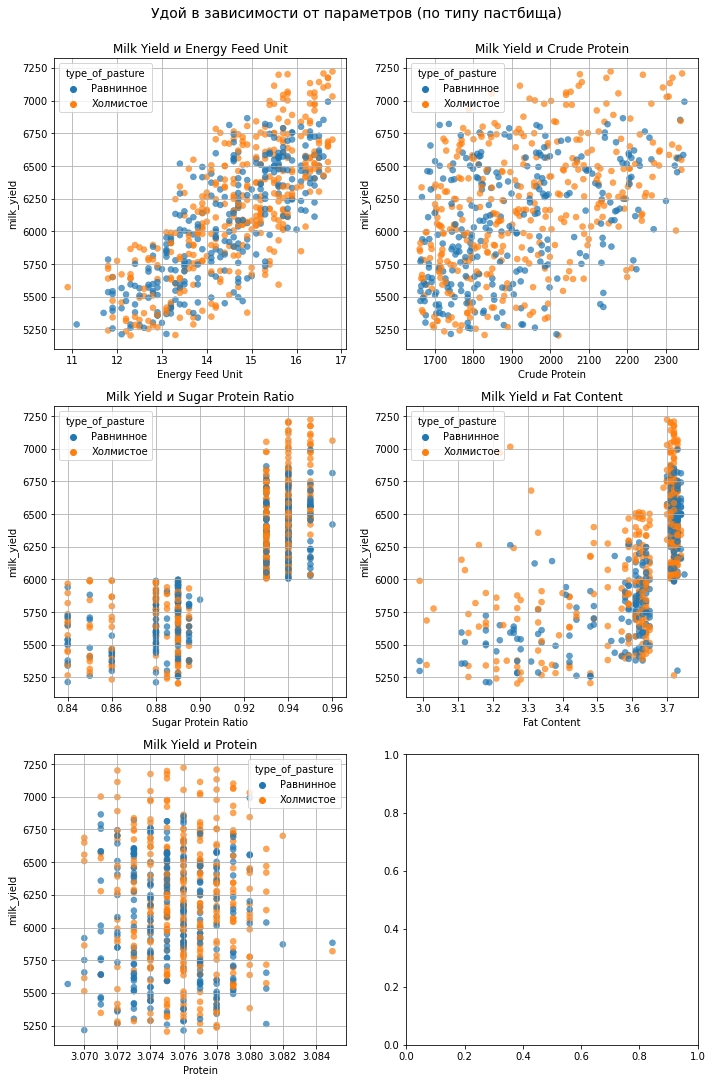

In [67]:
plot_scatter_by_category(
    df=ferma_main,
    num_features=num_features,
    category='type_of_pasture',
    target='milk_yield',
    title='Удой в зависимости от параметров (по типу пастбища)',
    ncols=2
)

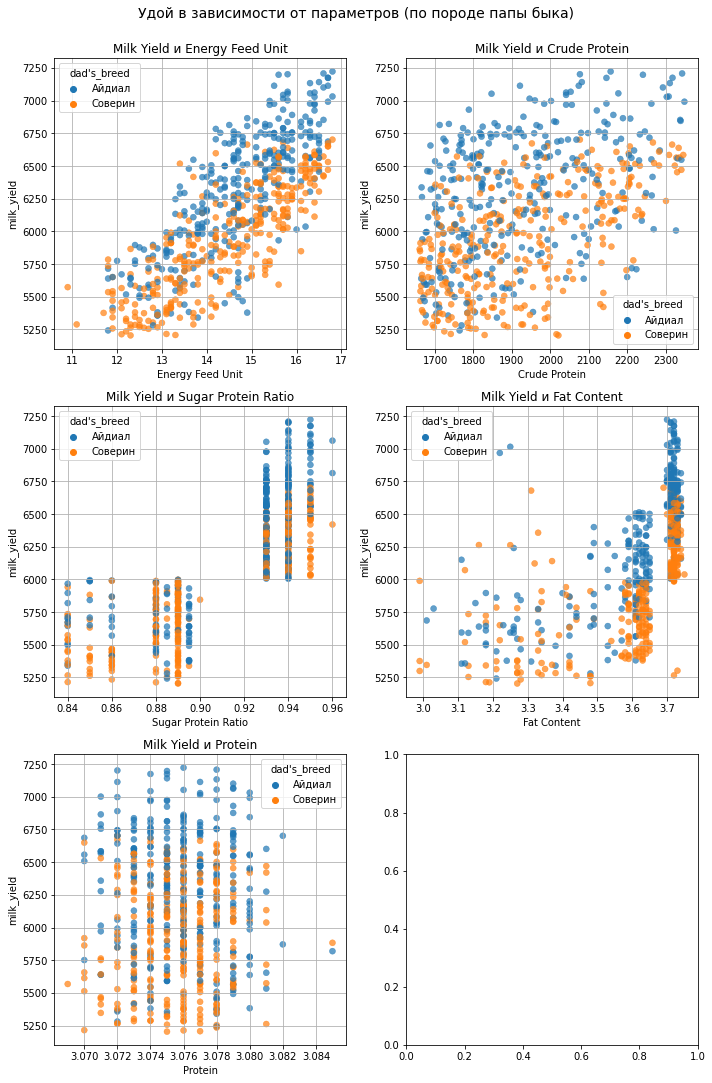

In [68]:
plot_scatter_by_category(
    df=ferma_main,
    num_features=num_features,
    category="dad's_breed",
    target='milk_yield',
    title='Удой в зависимости от параметров (по породе папы быка)',
    ncols=2
)

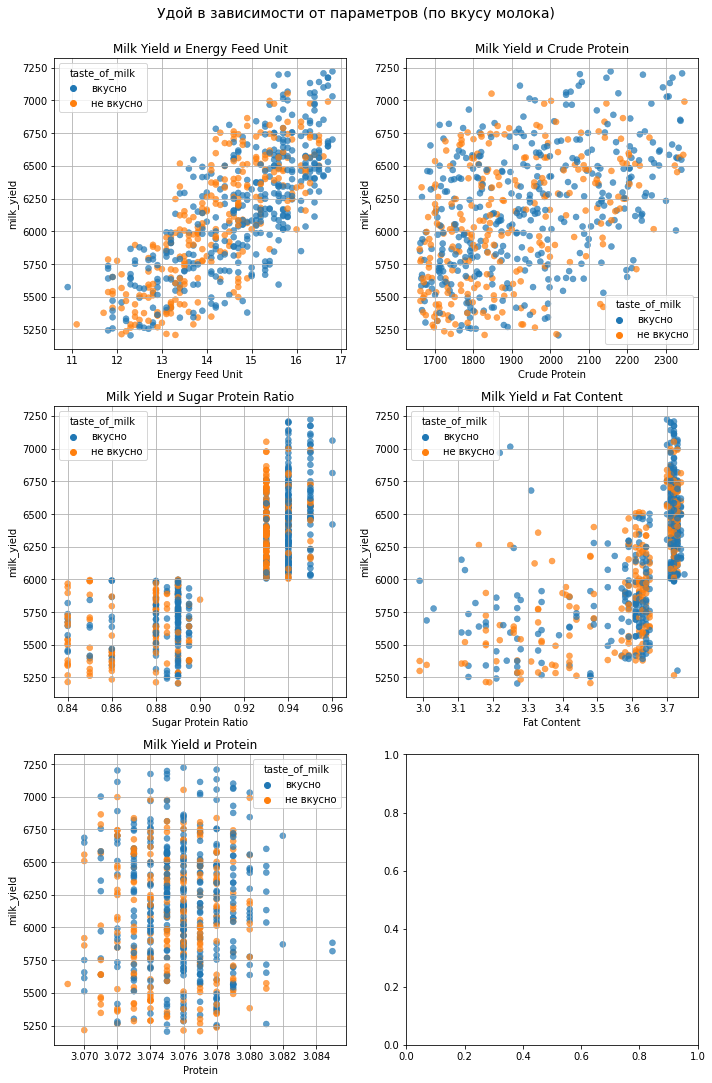

In [69]:
plot_scatter_by_category(
    df=ferma_main,
    num_features=num_features,
    category='taste_of_milk',
    target='milk_yield',
    title='Удой в зависимости от параметров (по вкусу молока)',
    ncols=2
)

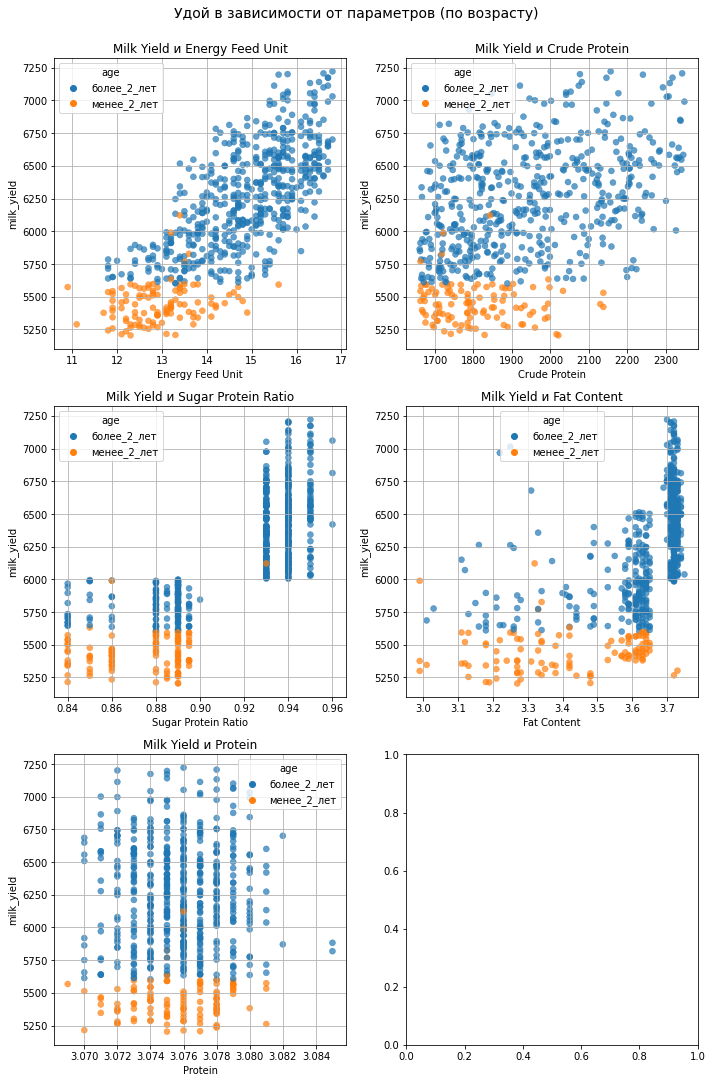

In [70]:
plot_scatter_by_category(
    df=ferma_main,
    num_features=num_features,
    category='age',
    target='milk_yield',
    title='Удой в зависимости от параметров (по возрасту)',
    ncols=2
)

#### Выводы

**Какой тип взаимосвязи между целевым и входными признаками?**

Линейная положительная связь у удоя с ЭКЕ.

**Есть ли нелинейные связи между целевым и входными признаками? Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?**

Нелинейные зависимости у удоя с белком в процентах. Не думаю, что нужны доп признаки.

**Наблюдается ли мультиколлинеарность между входными признаками?**

Сильная корреляция между ЭКЕ и СПО, признаки могут быть между собой сильно связаны.

**Наблюдения по категориальным признакам**
1. По породе: по данным у РефлешнСоверинг больше СПО и жирность молока выше, при этом меньший процент белка по сравнению со второй породой Вис Бик Айдиал.
2. По типу пастбища: все показатели выше у коров, которые пасутся на холмистом типе пастбища (возможно это видно на графике из-за бОльшего кол-ва данных).
3. По породе папы-быка: по графикам видим что выигрывает в удое больше Айдиал (опять же из предыдущих графиков можно предположить, что просто данных по ним больше).
4. По вкусу молока: вкусное молоко отличается высокой жирностью, при это наблюдается у коров, которым давали больше корма с высоким СПО.
5. По возрасту коровы: тут мне кажется все логичным, что коровы старше 2х лет дают больше молока. 


## Обучение модели линейной регрессии

### Первая модель
Первым шагом уберем ненужные столбы, такие как: ID, жирность (%), белок (%), вкус молока. ID не несет информационной ценности, а остальные параметры это описание молока (они не влияют на кол-во удоя). И сразу поделим датасет на выборки.

In [71]:
X = ferma_main.drop(['id', 'milk_yield', 'fat_content', 'protein', 'taste_of_milk'], axis=1)
y = ferma_main['milk_yield']

X.info(), y.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   energy_feed_unit     628 non-null    float64
 1   crude_protein        628 non-null    int64  
 2   sugar_protein_ratio  628 non-null    float64
 3   breed                628 non-null    object 
 4   type_of_pasture      628 non-null    object 
 5   dad's_breed          628 non-null    object 
 6   age                  628 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 39.2+ KB


(None,
 0    5863
 1    5529
 2    5810
 3    5895
 4    5302
 Name: milk_yield, dtype: int64)

Второй шаг: разбиваем на тренировочную и тестовую выборки.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42
)
X_train

,energy_feed_unit,crude_protein,sugar_protein_ratio,breed,type_of_pasture,dad's_breed,age
508,16.5,2123,0.940,РефлешнСоверинг,Холмистое,Соверин,более_2_лет
383,12.5,1889,0.890,РефлешнСоверинг,Холмистое,Соверин,менее_2_лет
587,14.7,1671,0.880,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет
197,14.4,2063,0.940,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет
328,13.1,2077,0.890,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет
...,...,...,...,...,...,...,...
72,13.7,2212,0.895,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет
107,14.9,1742,0.930,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет
271,13.4,1775,0.880,РефлешнСоверинг,Равнинное,Айдиал,более_2_лет
436,13.1,1949,0.880,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет


Далее стандартизируем данные.

In [73]:
num = ['energy_feed_unit', 'crude_protein', 'sugar_protein_ratio']
cat = ['breed', 'type_of_pasture', "dad's_breed", 'age']

In [74]:
# обработка количественных признаков
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num])
X_test_num = scaler.transform(X_test[num])

In [75]:
# обработка категориальных признаков
encoder = OneHotEncoder(sparse=False)

X_train_cat = encoder.fit_transform(X_train[cat])
X_test_cat = encoder.transform(X_test[cat])

# объединим признаки
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final = np.hstack([X_test_num, X_test_cat])

Обучаем модель и получаем предсказания.

In [76]:
model = LinearRegression()
model.fit(X_train_final, y_train)

y_pred = model.predict(X_test_final)

Рассчитаем MAE и R² для оценки качества модели.

In [77]:
mse1 = mean_squared_error(y_test, y_pred)
rmse1 =  mean_squared_error(y_test, y_pred, squared=False)
mae1 = mean_absolute_error(y_test, y_pred)
r2_1 = r2_score(y_test, y_pred)

print(f'MSE: {mse1:.1f}')
print(f'RMSE: {rmse1:.1f}')
print(f'MAE: {mae1:.1f}')
print(f'R²: {r2_1:.3f}')

MSE: 43887.0
RMSE: 209.5
MAE: 164.2
R²: 0.784


Проведем анализ остатков.

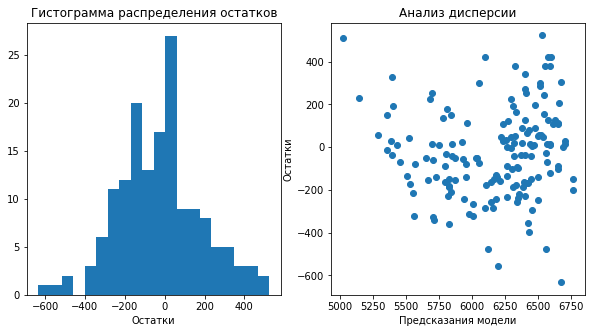

In [78]:
residuals = y_test - y_pred

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_pred, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

#### Выводы

MSE: 43887.0

RMSE: 209.5

MAE: 164.2

R²: 0.784

Остатки случайны, распределение скошено влево, большинство остатков от -300 до 300, а также есть выбросы (на графике в районе -600). Модель склонна приуменьшать предсказания.

Дальнейшая работа будет полезна для повышения точности и надежности модели.

### Вторая модель

In [79]:
X.shape

(628, 7)

In [80]:
# преобразуем СПО в бинарный категориальный признак и убераем основной из данных
X['spr_low'] = (X['sugar_protein_ratio'] < 0.91).astype(int)
X['spr_high'] = (X['sugar_protein_ratio'] >= 0.91).astype(int)

X = X.drop(columns=['sugar_protein_ratio'])
X.shape

(628, 8)

In [81]:
# добавляем квадрат ЭКЕ новым столбцом (доп признак)
X['efu_sq'] = X['energy_feed_unit'] ** 2
X.shape, X.head()

((628, 9),
    energy_feed_unit  crude_protein            breed type_of_pasture  \
 0              14.2           1743   Вис Бик Айдиал       Равнинное   
 1              12.8           2138   Вис Бик Айдиал       Равнинное   
 2              14.0           1854  РефлешнСоверинг       Холмистое   
 3              12.4           2012  РефлешнСоверинг       Холмистое   
 4              12.8           1675   Вис Бик Айдиал       Равнинное   
 
   dad's_breed          age  spr_low  spr_high  efu_sq  
 0      Айдиал  более_2_лет        1         0  201.64  
 1     Соверин  менее_2_лет        1         0  163.84  
 2     Соверин  более_2_лет        1         0  196.00  
 3      Айдиал  более_2_лет        1         0  153.76  
 4     Соверин  менее_2_лет        1         0  163.84  )

In [82]:
num1 = ['energy_feed_unit', 'crude_protein', 'efu_sq']
cat1 = ['breed', "dad's_breed", 'type_of_pasture', 'age', 'spr_low', 'spr_high']

# разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42
)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num1),
    ('cat', OneHotEncoder(), cat1)
])


X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# обучение модели
model = LinearRegression()
model.fit(X_train_proc, y_train)

# предсказание
y_pred = model.predict(X_test_proc)

In [83]:
# оценка качества модели
mse2 = mean_squared_error(y_test, y_pred)
rmse2 =  mean_squared_error(y_test, y_pred, squared=False)
mae2 = mean_absolute_error(y_test, y_pred)
r2_2 = r2_score(y_test, y_pred)

print(f'MSE: {mse2:.1f}')
print(f'RMSE: {rmse2:.1f}')
print(f'MAE: {mae2:.1f}')
print(f'R²: {r2_2:.3f}')

MSE: 37187.2
RMSE: 192.8
MAE: 150.8
R²: 0.817


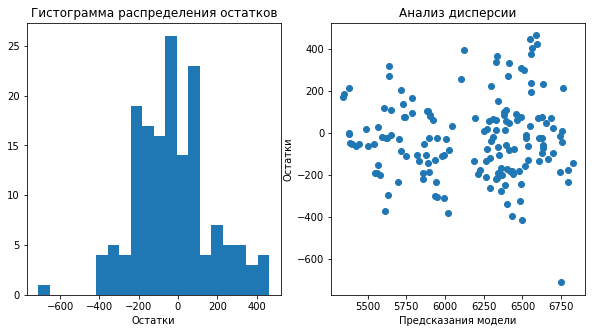

In [84]:
# анализ остатков
residuals = y_test - y_pred

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_pred, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

#### Выводы

MSE: 37187.2

RMSE: 192.8

MAE: 150.8

R²: 0.817

Распределение стало более симметричным, теперь бОльшая часть от -200 до 100. Выбросы все так же присутсвуют, но их меньше. Остатки разбросаны случайно, но уже ближе к 0.

Метрики улучшились, как и вид остатков стал лучше. Дальнейшая работа будет полезна для повышения точности и надежности модели.

### Третья модель

In [85]:
# объеденим датафреймы
df = ferma_main.merge(ferma_dad[['id', "dad's_name"]], on='id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   628 non-null    int64  
 1   milk_yield           628 non-null    int64  
 2   energy_feed_unit     628 non-null    float64
 3   crude_protein        628 non-null    int64  
 4   sugar_protein_ratio  628 non-null    float64
 5   breed                628 non-null    object 
 6   type_of_pasture      628 non-null    object 
 7   dad's_breed          628 non-null    object 
 8   fat_content          628 non-null    float64
 9   protein              628 non-null    float64
 10  taste_of_milk        628 non-null    object 
 11  age                  628 non-null    object 
 12  dad's_name           628 non-null    object 
dtypes: float64(4), int64(3), object(6)
memory usage: 68.7+ KB


In [86]:
df.head(), df.shape

(   id  milk_yield  energy_feed_unit  crude_protein  sugar_protein_ratio  \
 0   1        5863              14.2           1743                0.890   
 1   2        5529              12.8           2138                0.890   
 2   3        5810              14.0           1854                0.885   
 3   4        5895              12.4           2012                0.885   
 4   5        5302              12.8           1675                0.885   
 
              breed type_of_pasture dad's_breed  fat_content  protein  \
 0   Вис Бик Айдиал       Равнинное      Айдиал         3.58    3.076   
 1   Вис Бик Айдиал       Равнинное     Соверин         3.54    3.079   
 2  РефлешнСоверинг       Холмистое     Соверин         3.59    3.074   
 3  РефлешнСоверинг       Холмистое      Айдиал         3.40    3.075   
 4   Вис Бик Айдиал       Равнинное     Соверин         3.73    3.073   
 
   taste_of_milk          age dad's_name  
 0        вкусно  более_2_лет     Буйный  
 1        вкусно

In [87]:
df['spr_low'] = (df['sugar_protein_ratio'] < 0.91).astype(int)
df['spr_high'] = (df['sugar_protein_ratio'] >= 0.91).astype(int)

df = df.drop(columns=['sugar_protein_ratio'])

df['efu_sq'] = df['energy_feed_unit'] ** 2
df.shape, df.head()

((628, 15),
    id  milk_yield  energy_feed_unit  crude_protein            breed  \
 0   1        5863              14.2           1743   Вис Бик Айдиал   
 1   2        5529              12.8           2138   Вис Бик Айдиал   
 2   3        5810              14.0           1854  РефлешнСоверинг   
 3   4        5895              12.4           2012  РефлешнСоверинг   
 4   5        5302              12.8           1675   Вис Бик Айдиал   
 
   type_of_pasture dad's_breed  fat_content  protein taste_of_milk  \
 0       Равнинное      Айдиал         3.58    3.076        вкусно   
 1       Равнинное     Соверин         3.54    3.079        вкусно   
 2       Холмистое     Соверин         3.59    3.074     не вкусно   
 3       Холмистое      Айдиал         3.40    3.075     не вкусно   
 4       Равнинное     Соверин         3.73    3.073        вкусно   
 
            age dad's_name  spr_low  spr_high  efu_sq  
 0  более_2_лет     Буйный        1         0  201.64  
 1  менее_2_лет   Со

In [88]:
X = df.drop(['id', 'milk_yield', 'fat_content', 'protein', 'taste_of_milk'], axis=1)
y = df['milk_yield']
X.head()

,energy_feed_unit,crude_protein,breed,type_of_pasture,dad's_breed,age,dad's_name,spr_low,spr_high,efu_sq
0,14.2,1743,Вис Бик Айдиал,Равнинное,Айдиал,более_2_лет,Буйный,1,0,201.64
1,12.8,2138,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,Соловчик,1,0,163.84
2,14.0,1854,РефлешнСоверинг,Холмистое,Соверин,более_2_лет,Барин,1,0,196.00
3,12.4,2012,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,Буйный,1,0,153.76
4,12.8,1675,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,Барин,1,0,163.84


In [89]:
num2 = ['energy_feed_unit', 'crude_protein', 'efu_sq']
cat2 = ['breed', "dad's_breed", 'type_of_pasture', 'age', "dad's_name", 'spr_low', 'spr_high']


# разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42
)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num2),
    ('cat', OneHotEncoder(), cat2)
])

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# обучение модели
model = LinearRegression()
model.fit(X_train_proc, y_train)

# предсказание
y_pred = model.predict(X_test_proc)

In [90]:
# оценка качества модели
mse3 = mean_squared_error(y_test, y_pred)
rmse3 =  mean_squared_error(y_test, y_pred, squared=False)
mae3 = mean_absolute_error(y_test, y_pred)
r2_3 = r2_score(y_test, y_pred)

print(f'MSE: {mse3:.1f}')
print(f'RMSE: {rmse3:.1f}')
print(f'MAE: {mae3:.1f}')
print(f'R²: {r2_3:.3f}')

MSE: 34844.1
RMSE: 186.7
MAE: 145.5
R²: 0.829


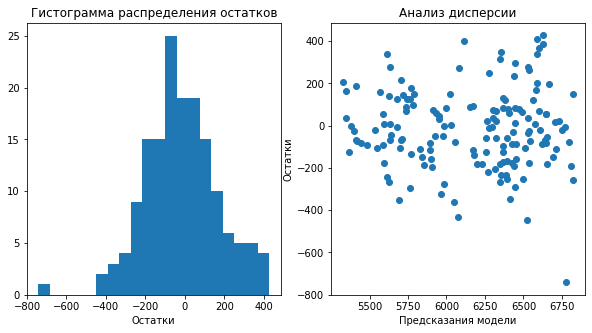

In [91]:
# анализ остатков
residuals = y_test - y_pred

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins=20)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(y_pred, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

#### Выводы

MSE: 34844.1

RMSE: 186.7

MAE: 145.5

R²: 0.829

Распределение стало ближе к нормальному. Выбросы все так же присутствуют, их еще меньше и меньше их влияние. Остатки разбросаны случайно, но уже ближе к 0.

Модель улучшилась после добавления нового признака имени папы-быка.

### Сравнение 3х моделей

В первой модели:
- MSE: 43887.0
- RMSE: 209.5
- MAE: 164.2
- R²: 0.784

Во второй модели:
- MSE: 37187.2
- RMSE: 192.8
- MAE: 150.8
- R²: 0.817

В третьей модели:
- MSE: 34844.1
- RMSE: 186.7
- MAE: 145.5
- R²: 0.829

Предсказания улучшились на 4,5%, а средняя ошибка прогноза удоя за год уменьшилась на 18,7 кг (по MAE).

Распределение анализов остатков приблизилось к нормальному, а остатков стало меньше и приблизились к 0 (значит оказывают наименьшее влияние из 3х моделей).

Лучшая модель 3.

In [92]:
# доверительный интервал прогноза лучшей модели
y_train_pred = model.predict(X_train_proc)

predicted_milk_yield = 6000

residuals = y_train - y_train_pred
lower_quantile = np.percentile(residuals, 5)
upper_quantile = np.percentile(residuals, 95)

f'90% доверительный интервал: от {predicted_milk_yield + lower_quantile:.1f} до {predicted_milk_yield + upper_quantile:.1f} кг'

'90% доверительный интервал: от 5724.7 до 6299.6 кг'

In [93]:
residual_mean = residuals.mean()
residual_std = residuals.std()

# уровень доверия
confidence_level = 0.90

z_score = st.norm.ppf((1 + confidence_level) / 2)

margin_of_error = z_score * residual_std
ci_low_norm = predicted_milk_yield + residual_mean - margin_of_error
ci_high_norm = predicted_milk_yield + residual_mean + margin_of_error

f'{int(confidence_level*100)}% доверительный интервал (через нормальное распределение): от {ci_low_norm:.1f} до {ci_high_norm:.1f} кг'

'90% доверительный интервал (через нормальное распределение): от 5702.4 до 6297.6 кг'

### Прогноз удоя коров с помощью 3 модели

In [94]:
df_new_cows = cow_buy
df_new_cows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   breed                  16 non-null     object 
 1   type_of_pasture        16 non-null     object 
 2   dad's_breed            16 non-null     object 
 3   dad's_name             16 non-null     object 
 4   current_fat_content    16 non-null     float64
 5   current_protein_level  16 non-null     float64
 6   age                    16 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.0+ KB


In [95]:
df_new_cows.head()

,breed,type_of_pasture,dad's_breed,dad's_name,current_fat_content,current_protein_level,age
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [96]:
df_new_cows['energy_feed_unit'] = ferma_main['energy_feed_unit'].mean() * 1.05
df_new_cows['crude_protein'] = ferma_main['crude_protein'].mean() * 1.05
df_new_cows['sugar_protein_ratio'] = ferma_main['sugar_protein_ratio'].mean() * 1.05

df_new_cows['spr_low'] = (df_new_cows['sugar_protein_ratio'] < 1.5).astype(int)
df_new_cows['spr_high'] = (df_new_cows['sugar_protein_ratio'] >= 1.5).astype(int)

df_new_cows['efu_sq'] = df_new_cows['energy_feed_unit'] ** 2

df_new_cows = df_new_cows.drop(columns=['current_fat_content', 'current_protein_level', 'sugar_protein_ratio'])

In [97]:
df_new_cows.head(), df_new_cows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   breed             16 non-null     object 
 1   type_of_pasture   16 non-null     object 
 2   dad's_breed       16 non-null     object 
 3   dad's_name        16 non-null     object 
 4   age               16 non-null     object 
 5   energy_feed_unit  16 non-null     float64
 6   crude_protein     16 non-null     float64
 7   spr_low           16 non-null     int64  
 8   spr_high          16 non-null     int64  
 9   efu_sq            16 non-null     float64
dtypes: float64(3), int64(2), object(5)
memory usage: 1.4+ KB


(             breed type_of_pasture dad's_breed dad's_name          age  \
 0   Вис Бик Айдиал       Холмистое      Айдиал   Геркулес  более_2_лет   
 1   Вис Бик Айдиал       Равнинное     Соверин     Буйный  менее_2_лет   
 2  РефлешнСоверинг       Равнинное     Соверин      Барин  более_2_лет   
 3  РефлешнСоверинг       Холмистое      Айдиал     Буйный  более_2_лет   
 4  РефлешнСоверинг       Равнинное      Айдиал     Буйный  более_2_лет   
 
    energy_feed_unit  crude_protein  spr_low  spr_high      efu_sq  
 0         15.276162    2019.947532        1         0  233.361138  
 1         15.276162    2019.947532        1         0  233.361138  
 2         15.276162    2019.947532        1         0  233.361138  
 3         15.276162    2019.947532        1         0  233.361138  
 4         15.276162    2019.947532        1         0  233.361138  ,
 None)

In [98]:
expected_columns = ['energy_feed_unit', 'crude_protein', 'breed', 'type_of_pasture', "dad's_breed", 'age', "dad's_name",
                    'spr_low', 'spr_high', 'efu_sq']
df_new_cows = df_new_cows[expected_columns]

df_new_cows.head()

,energy_feed_unit,crude_protein,breed,type_of_pasture,dad's_breed,age,dad's_name,spr_low,spr_high,efu_sq
0,15.276162,2019.947532,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет,Геркулес,1,0,233.361138
1,15.276162,2019.947532,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,Буйный,1,0,233.361138
2,15.276162,2019.947532,РефлешнСоверинг,Равнинное,Соверин,более_2_лет,Барин,1,0,233.361138
3,15.276162,2019.947532,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,Буйный,1,0,233.361138
4,15.276162,2019.947532,РефлешнСоверинг,Равнинное,Айдиал,более_2_лет,Буйный,1,0,233.361138


In [99]:
X_new_cow = preprocessor.transform(df_new_cows)

In [100]:
pred_yield_new = model.predict(X_new_cow)
df_new_cows['milk_yield'] = pred_yield_new
df_new_cows

,energy_feed_unit,crude_protein,breed,type_of_pasture,dad's_breed,age,dad's_name,spr_low,spr_high,efu_sq,milk_yield
0,15.276162,2019.947532,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет,Геркулес,1,0,233.361138,6220.486221
1,15.276162,2019.947532,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,Буйный,1,0,233.361138,5948.118884
2,15.276162,2019.947532,РефлешнСоверинг,Равнинное,Соверин,более_2_лет,Барин,1,0,233.361138,5902.441952
3,15.276162,2019.947532,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,Буйный,1,0,233.361138,6211.180177
4,15.276162,2019.947532,РефлешнСоверинг,Равнинное,Айдиал,более_2_лет,Буйный,1,0,233.361138,6164.499242
5,15.276162,2019.947532,РефлешнСоверинг,Равнинное,Соверин,менее_2_лет,Геркулес,1,0,233.361138,5980.887409
6,15.276162,2019.947532,Вис Бик Айдиал,Равнинное,Соверин,более_2_лет,Буйный,1,0,233.361138,6180.851187
7,15.276162,2019.947532,РефлешнСоверинг,Холмистое,Айдиал,менее_2_лет,Буйный,1,0,233.361138,5978.447874
8,15.276162,2019.947532,Вис Бик Айдиал,Холмистое,Соверин,более_2_лет,Соловчик,1,0,233.361138,5963.882173
9,15.276162,2019.947532,РефлешнСоверинг,Равнинное,Соверин,более_2_лет,Геркулес,1,0,233.361138,6213.619712


## Обучение модели логистической регрессии

In [101]:
df_log = ferma_main.merge(ferma_dad[['id', "dad's_name"]], on='id', how='left')
df_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   628 non-null    int64  
 1   milk_yield           628 non-null    int64  
 2   energy_feed_unit     628 non-null    float64
 3   crude_protein        628 non-null    int64  
 4   sugar_protein_ratio  628 non-null    float64
 5   breed                628 non-null    object 
 6   type_of_pasture      628 non-null    object 
 7   dad's_breed          628 non-null    object 
 8   fat_content          628 non-null    float64
 9   protein              628 non-null    float64
 10  taste_of_milk        628 non-null    object 
 11  age                  628 non-null    object 
 12  dad's_name           628 non-null    object 
dtypes: float64(4), int64(3), object(6)
memory usage: 68.7+ KB


In [102]:
X_log = df_log.drop(columns=['id', 'milk_yield', 'taste_of_milk'], axis=1)
y_log = df_log['taste_of_milk']
X_log

,energy_feed_unit,crude_protein,sugar_protein_ratio,breed,type_of_pasture,dad's_breed,fat_content,protein,age,dad's_name
0,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,более_2_лет,Буйный
1,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,менее_2_лет,Соловчик
2,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,более_2_лет,Барин
3,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,более_2_лет,Буйный
4,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,менее_2_лет,Барин
...,...,...,...,...,...,...,...,...,...,...
623,15.4,1964,0.940,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,более_2_лет,Буйный
624,12.9,1700,0.880,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,менее_2_лет,Барин
625,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,более_2_лет,Барин
626,13.8,1994,0.890,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,более_2_лет,Барин


In [103]:
# разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_log,
    y_log,
    random_state=42
)

num_log = ['energy_feed_unit', 'crude_protein', 'sugar_protein_ratio', 'fat_content', 'protein',]
cat_log = ['breed', 'type_of_pasture', "dad's_breed", 'age', "dad's_name"]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_log),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_log)
])

X_train_log = preprocessor.fit_transform(X_train)
X_test_log = preprocessor.transform(X_test)

In [104]:
# обучение модели
clf = LogisticRegression()
clf = clf.fit(X_train_log, y_train)

# предсказание
y_pred_log = clf.predict(X_test_log)

In [105]:
# оценка качества
accuracy = accuracy_score(y_test, y_pred_log)
precision = precision_score(y_test, y_pred_log, pos_label='вкусно')
recall = recall_score(y_test, y_pred_log, pos_label='вкусно')

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')

Accuracy: 0.618
Precision: 0.615
Recall: 0.852


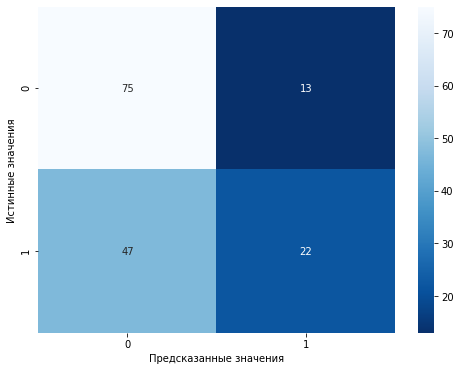

In [106]:
# матрица ошибок
cm = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения');

In [107]:
clf.classes_

array(['вкусно', 'не вкусно'], dtype=object)

### Анализ

Accuracy: 0.618. Модель прогнозирует правильно только в 61.8% случаев.

Precision: 0.615. Модель помечает что молоко вкусное только в 61.5%.

Recall: 0.852. Модель обнаруживает 85.2% всех коров, которые действительно дают вкусное молоко.

Модель дает ложноположительные результаты чаще чем ложнонегативные.

Если фермер покупает корову, которая была предсказана как дающая вкусное молоко, а по факту ее молоко не вкусное, то это потеря финансов и времени. Также если фермер не купит корову, которая дает на самом деле вкусное молоко, нежелательный прогноз, но не такой критичный.

Главное для заказчика — вкусное молоко, поэтому нам критичнее ошибка первого рода. Увеличим порог, чтобы повысить Precision (свести ложноположительные ответы к 0).


In [119]:
print(f"Классы модели: {clf.classes_}")
positive_class_index = list(clf.classes_).index('вкусно')
y_proba_log = clf.predict_proba(X_test_log)[:, positive_class_index]

y_pred_log = ['вкусно' if p >= 0.5 else 'не вкусно' for p in y_proba_log]

data = pd.DataFrame({'Истенные': y_test, 'Предсказанные': y_proba_log})
data = data.sort_values(by='Предсказанные', ascending=False)
print(data.head(20))

Классы модели: ['вкусно' 'не вкусно']
      Истенные  Предсказанные
597     вкусно       0.845545
63      вкусно       0.826279
287     вкусно       0.816645
587  не вкусно       0.811733
56      вкусно       0.809443
286  не вкусно       0.803067
188     вкусно       0.802975
281     вкусно       0.802856
456     вкусно       0.797952
244     вкусно       0.797431
328     вкусно       0.789890
534     вкусно       0.789618
599     вкусно       0.789069
583     вкусно       0.778467
82      вкусно       0.776318
284     вкусно       0.771156
31      вкусно       0.770712
545  не вкусно       0.768866
77      вкусно       0.766459
227     вкусно       0.765929


In [120]:
thresholds = np.arange(0.5, 1.0, 0.001)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred = ['вкусно' if p >= threshold else 'не вкусно' for p in y_proba_log]
    precision = precision_score(y_test, y_pred, pos_label='вкусно', zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label='вкусно', zero_division=0)
    precision_scores.append(precision)
    recall_scores.append(recall)

results = pd.DataFrame({
    'threshold': thresholds,
    'precision': precision_scores,
    'recall': recall_scores
})

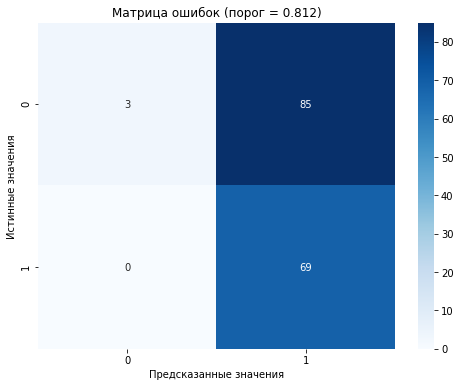

In [123]:
best_threshold = 0.812
y_pred_best = ['вкусно' if p >= best_threshold else 'не вкусно' for p in y_proba_log]

# матрица ошибок
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Матрица ошибок (порог = {best_threshold:.3f})')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения');

Луший порог найден 0.788. Теперь сделаем предсказание.

In [111]:
df_milk = cow_buy
df_milk['energy_feed_unit'] = ferma_main['energy_feed_unit'].mean() * 1.05
df_milk['crude_protein'] = ferma_main['crude_protein'].mean() * 1.05
df_milk['sugar_protein_ratio'] = ferma_main['sugar_protein_ratio'].mean() * 1.05
df_milk = df_milk.rename(columns={'current_fat_content': 'fat_content', 'current_protein_level': 'protein'})
df_milk = df_milk.drop(columns=['spr_low', 'spr_high', 'efu_sq'])
expected_columns1 = ['energy_feed_unit', 'crude_protein', 'sugar_protein_ratio', 'breed', 'type_of_pasture',
                     "dad's_breed", 'fat_content', 'protein', 'age', "dad's_name",]
df_milk = df_milk[expected_columns1]

df_milk.head()

,energy_feed_unit,crude_protein,sugar_protein_ratio,breed,type_of_pasture,dad's_breed,fat_content,protein,age,dad's_name
0,15.276162,2019.947532,0.958744,Вис Бик Айдиал,Холмистое,Айдиал,3.58,3.076,более_2_лет,Геркулес
1,15.276162,2019.947532,0.958744,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.081,менее_2_лет,Буйный
2,15.276162,2019.947532,0.958744,РефлешнСоверинг,Равнинное,Соверин,3.59,3.074,более_2_лет,Барин
3,15.276162,2019.947532,0.958744,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.061,более_2_лет,Буйный
4,15.276162,2019.947532,0.958744,РефлешнСоверинг,Равнинное,Айдиал,3.64,3.074,более_2_лет,Буйный


In [112]:
X_milk_proc = preprocessor.transform(df_milk)

y_proba_milk = clf.predict_proba(X_milk_proc)[:, 0]  # Вероятность "вкусно"

# применяем порог
y_pred_milk = ['вкусно' if p >= best_threshold else 'не вкусно' for p in y_proba_milk]

# Добавляем результат в датафрейм
df_new_cows['taste_of_milk'] = y_pred_milk
df_new_cows['prob_of_delicious_milk'] = y_proba_milk

In [113]:
df_new_cows.head(20)

,energy_feed_unit,crude_protein,breed,type_of_pasture,dad's_breed,age,dad's_name,spr_low,spr_high,efu_sq,milk_yield,taste_of_milk,prob_of_delicious_milk
0,15.276162,2019.947532,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет,Геркулес,1,0,233.361138,6220.486221,не вкусно,0.765934
1,15.276162,2019.947532,Вис Бик Айдиал,Равнинное,Соверин,менее_2_лет,Буйный,1,0,233.361138,5948.118884,не вкусно,0.740547
2,15.276162,2019.947532,РефлешнСоверинг,Равнинное,Соверин,более_2_лет,Барин,1,0,233.361138,5902.441952,не вкусно,0.695016
3,15.276162,2019.947532,РефлешнСоверинг,Холмистое,Айдиал,более_2_лет,Буйный,1,0,233.361138,6211.180177,не вкусно,0.479735
4,15.276162,2019.947532,РефлешнСоверинг,Равнинное,Айдиал,более_2_лет,Буйный,1,0,233.361138,6164.499242,не вкусно,0.608521
5,15.276162,2019.947532,РефлешнСоверинг,Равнинное,Соверин,менее_2_лет,Геркулес,1,0,233.361138,5980.887409,не вкусно,0.170176
6,15.276162,2019.947532,Вис Бик Айдиал,Равнинное,Соверин,более_2_лет,Буйный,1,0,233.361138,6180.851187,не вкусно,0.723541
7,15.276162,2019.947532,РефлешнСоверинг,Холмистое,Айдиал,менее_2_лет,Буйный,1,0,233.361138,5978.447874,вкусно,0.814760
8,15.276162,2019.947532,Вис Бик Айдиал,Холмистое,Соверин,более_2_лет,Соловчик,1,0,233.361138,5963.882173,не вкусно,0.255748
9,15.276162,2019.947532,РефлешнСоверинг,Равнинное,Соверин,более_2_лет,Геркулес,1,0,233.361138,6213.619712,не вкусно,0.582701


## Итоговые выводы

### 1. Предобработка данных

Были изменены типы данных в датафреймах ferma_main и cow_buy со строки на тип float будет полезно при расчетах. Еще были замечены полные дубликаты в данных таблицах, они удалены (теперь на 4 коровы стало меньше для выбора покупки). Пропусков нет.

### 2. Исследовательский анализ данных
1. Данные о стаде фермера и об отцах коров фермера

Был обнаружен выброс в виде 45616 кг удоя в год, данные неправдоподобны, поэтому данная строка была удалена из датафрейма. Также показаны в boxplot выбросы в проценте жирности и белка, но их убирать не буду.

В данных о стаде фермера 628 коров. Большая часть стада старше 2х лет, дает вкусное молоко, пасется на холмистом пастбище и породы Вис Бик Айдиал. Породы отцов быков примерно поровну.

Средние характеристики корма:

ЭКЕ в среднем от 13,5 до 15,6 (среднее 14,55).
Сырой протеин в основном от 1771.75 гр до 2062,25 (медиана 1888 гр).
СПО в промежутке от 0,89 до 0,94 (медиана 0.93).
Средние характеристики молока:

Удой в основном от 5749 до 6501 кг в среднем 6125.97 кг.
Процент жирности от 3.59 до 3.72 (медиана 3.65 %).
Процент белка от 3.074 до 3.077 (среднее 3.076 %).
Брала в некоторых пунктах медиану, т.к. данные на графиках скошены в большую или меньшую стороны, а это влияет на среднее значение.

Топ-3 отцов по количеству коров:
- Барин
- Буйный
- Соловчик

2. Данные о коровах "ЭкоФермы"

Жирность молока у большинства коров от 3,5% (среднее 3,57%), а уровень белка от 3.059 до 3.076 (среднее 3.07).

Породы коров как и тип пастбища ровно поровну 50 на 50%. Также большая часть коров старше 2х лет.

Топ-3 отцов по количеству коров:
- Буйный
- Геркулес
- Соловчик/Барин

Преобладает порода папы-быка Соверин.

### 3. Корреляционный анализ

**Какой тип взаимосвязи между целевым и входными признаками?**

Линейная положительная связь у удоя с ЭКЕ.

**Есть ли нелинейные связи между целевым и входными признаками? Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?**

Нелинейные зависимости у удоя с белком в процентах. Не думаю, что нужны доп признаки.

**Наблюдается ли мультиколлинеарность между входными признаками?**

Сильная корреляция между ЭКЕ и СПО, признаки могут быть между собой сильно связаны.

**Наблюдения по категориальным признакам**
1. По породе: по данным у РефлешнСоверинг больше СПО и жирность молока выше, при этом меньший процент белка по сравнению со второй породой Вис Бик Айдиал.
2. По типу пастбища: все показатели выше у коров, которые пасутся на холмистом типе пастбища (возможно это видно на графике из-за бОльшего кол-ва данных).
3. По породе папы-быка: по графикам видим что выигрывает в удое больше Айдиал (опять же из предыдущих графиков можно предположить, что просто данных по ним больше).
4. По вкусу молока: вкусное молоко отличается высокой жирностью, при это наблюдается у коров, которым давали больше корма с высоким СПО.
5. По возрасту коровы: тут мне кажется все логичным, что коровы старше 2х лет дают больше молока. 

### 4. Обучение моделей линейной регрессии и логистической регрессии

Получилась у меня только одна корова, которая точно даст вкусное молоко, но она дает меньше 6000 кг удоя в год:

Индекс: 9. Удой в кг: 5978.45.

Я добавила в данные еще % прогноза вкусного молока, но есть риск что модель предсказала неверно.

Какие способы улучшения качества регрессионной модели вы использовали в этой задаче?

Добавление новых признаков и исключение нелинейности метрик. 

Возможно ли ещё улучшить результаты регрессионной модели? Если можно, то как? Если нет, то почему?

Можно улучшить, ведь нет пределов совершенству.. Думаю, стоит добавить дополнительные новые метрики или использовать другую модель обучения.

Какие метрики моделей классификации, в том числе логистической регрессии, важны при анализе рисков или экономических расчётов?

- Accuracy
- Precision
- Recall
- Анализ остатков (не метрика, но полезен в оценке качества)
- MSE, RMSE, MAE, R²